In [0]:
# Install pytorch and tqdm (if necessary)
!pip install torch
!pip install torchvision
!pip install tqdm

In [0]:
# Mount your google drive as the data drive
# This will require google authorization
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Handle imports

import math
import os
import datetime
import csv
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import numpy as np
import tqdm
import torch.nn.init as init
#import torchvision.models as models

from IPython import display

In [0]:
# The Args object will contain all of our parameters
# If you want to run with different arguments, create another Args object

class Args(object):
  def __init__(self, name='mnist', batch_size=64, test_batch_size=1000,
            epochs=10, lr=0.0001,optimizer='adam', momentum=0.5,
            seed=1, log_interval=100, dataset='mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='default',
            cuda=True):
    self.name = name # name for this training run. Don't use spaces.
    self.batch_size = batch_size
    self.test_batch_size = test_batch_size # Input batch size for testing
    self.epochs = epochs # Number of epochs to train
    self.lr = lr # Learning rate
    self.optimizer = optimizer # sgd/p1sgd/adam/rmsprop
    self.momentum = momentum # SGD Momentum
    self.seed = seed # Random seed
    self.log_interval = log_interval # Batches to wait before logging
                                     # detailed status. 0 = never
    self.dataset = dataset # mnist/fashion_mnist
    self.data_dir = data_dir
    self.model = model # default/P2Q7DoubleChannelsNet/P2Q7HalfChannelsNet/
                  # P2Q8BatchNormNet/P2Q9DropoutNet/P2Q10DropoutBatchnormNet/
                  # P2Q11ExtraConvNet/P2Q12RemoveLayerNet/P2Q13UltimateNet
    self.cuda = cuda and torch.cuda.is_available()

In [0]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
       ##modification 1, using dropout with residual branch
        x = F.dropout(x, p=0.1, training=self.training)
        ##modification 1 ends  https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cc5d0adf648e
        
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [0]:
def conv_bn_leru(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
    )

def down_pooling():
    return nn.MaxPool2d(2)

def up_pooling(in_channels, out_channels, kernel_size=2, stride=2):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# UNet class

class UNet(nn.Module):
    def __init__(self, input_channels=1, nclasses=10):
        super().__init__()
        # go down
        self.conv1 = conv_bn_leru(input_channels,64)
        self.conv2 = conv_bn_leru(64, 128)
        self.conv3 = conv_bn_leru(128, 256)
        self.conv4 = conv_bn_leru(256, 512)
        self.conv5 = conv_bn_leru(512, 1024)
        self.down_pooling = nn.MaxPool2d(2)

        # go up
        self.up_pool6 = up_pooling(1024, 512)
        self.conv6 = conv_bn_leru(1024, 512)
        self.up_pool7 = up_pooling(512, 256,kernel_size=3)
        self.conv7 = conv_bn_leru(512, 256)
        self.up_pool8 = up_pooling(256, 128)
        self.conv8 = conv_bn_leru(256, 128)
        self.up_pool9 = up_pooling(128, 64)
        self.conv9 = conv_bn_leru(128, 64)

        self.conv10 = nn.Conv2d(64, nclasses, 1)


        # test weight init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal(m.weight.data, a=0, mode='fan_out')
                if m.bias is not None:
                    m.bias.data.zero_()


    def forward(self, x):
        # normalize input data
        x = x/255.
        # go down
        x1 = self.conv1(x)
        p1 = self.down_pooling(x1)
        x2 = self.conv2(p1)
        p2 = self.down_pooling(x2)
        x3 = self.conv3(p2)
        p3 = self.down_pooling(x3)
        x4 = self.conv4(p3)
        #p4 = self.down_pooling(x4)
        #x5 = self.conv5(p4)

        # go up
        #p6 = self.up_pool6(x5)
        #print('\nshapes:',p6.shape,x4.shape,x5.shape)
        #x6 = torch.cat([p6, x4], dim=1)
        #x6 = self.conv6(x6)

        p7 = self.up_pool7(x4)
        #print('\nshapes:',p7.shape,x3.shape,x4.shape)
        x7 = torch.cat([p7, x3], dim=1)
        x7 = self.conv7(x7)

        p8 = self.up_pool8(x7)
        x8 = torch.cat([p8, x2], dim=1)
        x8 = self.conv8(x8)

        p9 = self.up_pool9(x8)
        x9 = torch.cat([p9, x1], dim=1)
        x9 = self.conv9(x9)


        output = self.conv10(x9)
        output = F.sigmoid(output)

        return output

class UNet2(nn.Module):
    def __init__(self, input_channels=1, nclasses=10):
        super().__init__()
        # go down
        self.conv1 = conv_bn_leru(input_channels,16)
        self.conv2 = conv_bn_leru(16, 32)
        self.conv3 = conv_bn_leru(32, 64)
        self.conv4 = conv_bn_leru(64, 128)
        self.conv5 = conv_bn_leru(128, 256)
        self.down_pooling = nn.MaxPool2d(2)

        # go up
        self.up_pool6 = up_pooling(256, 128)
        self.conv6 = conv_bn_leru(256, 128)
        self.up_pool7 = up_pooling(128, 64)
        self.conv7 = conv_bn_leru(128, 64)
        self.up_pool8 = up_pooling(64, 32)
        self.conv8 = conv_bn_leru(64, 32)
        self.up_pool9 = up_pooling(32, 16)
        self.conv9 = conv_bn_leru(32, 16)

        self.conv10 = nn.Conv2d(16, nclasses, 1)


        # test weight init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal(m.weight.data, a=0, mode='fan_out')
                if m.bias is not None:
                    m.bias.data.zero_()


    def forward(self, x):
        # normalize input data
        x = x/255.
        # go down
        x1 = self.conv1(x)
        p1 = self.down_pooling(x1)
        x2 = self.conv2(p1)
        p2 = self.down_pooling(x2)
        x3 = self.conv3(p2)
        p3 = self.down_pooling(x3)
        x4 = self.conv4(p3)
        p4 = self.down_pooling(x4)
        x5 = self.conv5(p4)

        # go up
        p6 = self.up_pool6(x5)
        x6 = torch.cat([p6, x4], dim=1)
        x6 = self.conv6(x6)

        p7 = self.up_pool7(x6)
        x7 = torch.cat([p7, x3], dim=1)
        x7 = self.conv7(x7)

        p8 = self.up_pool8(x7)
        x8 = torch.cat([p8, x2], dim=1)
        x8 = self.conv8(x8)

        p9 = self.up_pool9(x8)
        x9 = torch.cat([p9, x1], dim=1)
        x9 = self.conv9(x9)


        output = self.conv10(x9)
        output = F.sigmoid(output)

        return output

In [0]:
def prepare_dataset(args):
    # choose the dataset
    if args.dataset == 'mnist':
        DatasetClass = datasets.MNIST
    elif args.dataset == 'fashion_mnist':
        DatasetClass = datasets.FashionMNIST
    else:
        raise ValueError('unknown dataset: ' + args.dataset +
                ' try mnist or fashion_mnist')

    def time_stamp(fname, fmt='%m-%d-%H-%M_{fname}'):
        return datetime.datetime.now().strftime(fmt).format(fname=fname)
        
    training_run_name = time_stamp(args.dataset + '_' + args.name)

    kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

    # Create the dataset: mnist or fasion_mnist
    dataset_dir = os.path.join(args.data_dir, args.dataset)
    training_run_dir = os.path.join(args.data_dir, training_run_name)
    train_dataset = DatasetClass(
        dataset_dir, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ]))
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
    test_dataset = DatasetClass(
        dataset_dir, train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ]))
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    
    if not os.path.exists(training_run_dir):
        os.makedirs(training_run_dir)

    return train_loader, test_loader, train_dataset, test_dataset, training_run_dir

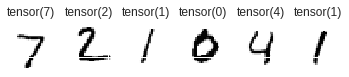

In [0]:
# visualize some images

args = Args()
_, _, _, test_dataset, _ = prepare_dataset(args)
images = test_dataset.test_data[:6]
labels = test_dataset.test_labels[:6]
fig, axes = plt.subplots(1,6)
for axis, img, lbl in zip(axes, images, labels):
    axis.imshow(img)
    axis.set_title(lbl)
    axis.set_yticklabels([])
    axis.set_xticklabels([])
plt.show()


In [0]:
def train(model, optimizer, train_loader, epoch, total_minibatch_count,
        train_losses, train_accs):
    # Training for a full epoch

    model.train()
    correct_count, total_loss, total_acc = 0., 0., 0.
    progress_bar = tqdm.tqdm(train_loader, desc='Training')
    
    for batch_idx, (data, target) in enumerate(progress_bar):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()

        # Forward prediction step
        output = model(data)
        computeloss=nn.CrossEntropyLoss()
        #computeloss=nn.BCELoss()
        loss = computeloss(output, target)
        #loss = computeloss(output, data)
        
        # Backpropagation step
        loss.backward()
        optimizer.step()

        # The batch has ended, determine the accuracy of the predicted outputs
        pred = output.data.max(1)[1]  

        # target labels and predictions are categorical values from 0 to 9.
        matches = target == pred
        accuracy = matches.float().mean()
        correct_count += matches.sum()

        if args.log_interval != 0 and \
                total_minibatch_count % args.log_interval == 0:

            train_losses.append(loss.data[0])
            train_accs.append(accuracy.data[0])
            
        total_loss += loss.data
        total_acc += accuracy.data
            
        progress_bar.set_description(
            'Epoch: {} loss: {:.4f}, acc: {:.2f}'.format(
                epoch, total_loss / (batch_idx + 1), total_acc / (batch_idx + 1)))
        #progress_bar.refresh()

        total_minibatch_count += 1

    return total_minibatch_count

In [0]:
def test(model, test_loader, epoch, total_minibatch_count,
        val_losses, val_accs):
    # Validation Testing
    model.eval()
    test_loss, correct = 0., 0.
    progress_bar = tqdm.tqdm(test_loader, desc='Validation')
    with torch.no_grad():
        for data, target in progress_bar:
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            computeloss=nn.CrossEntropyLoss()
            #computeloss=nn.BCELoss()
            test_loss += computeloss(output, target).data  # sum up batch loss
            #test_loss += computeloss(output, data).data  # sum up batch loss
            pred = output.data.max(1)[1]  # get the index of the max log-probability
            correct += (target == pred).float().sum()

    test_loss /= len(test_loader.dataset)
    
    acc = correct / len(test_loader.dataset)

    val_losses.append(test_loss)
    val_accs.append(acc)
    
    progress_bar.clear()
    progress_bar.write(
        '\nEpoch: {} validation test results - Average val_loss: {:.4f}, val_acc: {}/{} ({:.2f}%)'.format(
            epoch, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

    return acc

In [0]:
# Run the experiment
def run_experiment(args,fine_tuning):

    total_minibatch_count = 0

    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)

    train_loader, test_loader, _, _, run_path = prepare_dataset(args)
    #print("\n\nDataset:  ", args.dataset,  " Epochs:  " , args.epochs, "  lr:  ", args.lr ,"\n")
    epochs_to_run = args.epochs

    # Choose model
    # TODO add all the other models here if their parameter is specified
    if  args.model=='ResNet18':
        model=resnet18()
    elif args.model=='ResNet34':
        model=resnet34()
    elif args.model=='ResNet50':
        model=resnet50()
    elif args.model=='ResNet101':
        model=resnet101()
    elif args.model=='UNet':
        model=UNet()
    elif args.model in globals():
        model = globals()[args.model]()
    #elif args.model == 'ProjectResnetPretrained':
     #   model = ProjectResnetPretrained()
    else:
        raise ValueError('Unknown model type: ' + args.model)

    if args.cuda:
        model.cuda()

    # Choose optimizer
    if args.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    elif args.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr)  ## Added lr here to pass from down there
    elif args.optimizer == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters())
    else:
        raise ValueError('Unsupported optimizer: ' + args.optimizer)

    # Run the primary training loop, starting with validation accuracy of 0
    val_acc = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    if fine_tuning==1:
      path='/content/drive/My Drive/cs482/data/Q13_best_accuracy_checkpoints/' ## change the path to where thw checkpoint file is
      path=os.path.join(path + 'Ultimate_fashion_MNIST_20epochs.pkl') 
      cuda = torch.cuda.is_available()
      if cuda:
        checkpoint = torch.load(path)
      else:
          # Load GPU model on CPU
          checkpoint = torch.load(path,
                                  map_location=lambda storage,
                                  loc: storage)
      model.load_state_dict(checkpoint['state_dict'])
    for epoch in range(1, epochs_to_run + 1):
        
        # train for 1 epoch
               
        total_minibatch_count = train(model, optimizer, train_loader,
                                    epoch, total_minibatch_count,
                                    train_losses, train_accs)
        # validate progress on test dataset
        val_acc = test(model, test_loader, epoch, total_minibatch_count,
                       val_losses, val_accs)
        
    fig, axes = plt.subplots(1,4, figsize=(13,4))
    # plot the losses and acc
    plt.title(args.name)
    axes[0].plot(train_losses)
    axes[0].set_title("Loss")
    axes[1].plot(train_accs)
    axes[1].set_title("Acc")
    axes[2].plot(val_losses)
    axes[2].set_title("Val loss")
    axes[3].plot(val_accs)
    axes[3].set_title("Val Acc")
    
    # Write to csv file
    with open(os.path.join(run_path + 'train.csv'), 'w') as f:
        csvw = csv.writer(f, delimiter=',')
        for loss, acc in zip(train_losses, train_accs):
            csvw.writerow((loss, acc))

    # Predict and Test
    images, labels = next(iter(test_loader))
    if args.cuda:
        images, labels = images.cuda(), labels.cuda()
    output = model(images)
    predicted = torch.max(output, 1)[1]
    fig, axes = plt.subplots(1,6,figsize=(6,2))
    for i, (axis, img, lbl) in enumerate(zip(axes, images, predicted)):
        if i > 5:
            break
        img = img.permute(1,2,0).squeeze()
        axis.imshow(img)
        axis.set_title(lbl.data)
        axis.set_yticklabels([])
        axis.set_xticklabels([])
     
    if args.dataset == 'fashion_mnist' and val_acc > 0.92 and val_acc <= 1.0:
        print("Congratulations, you beat the Question 13 minimum of 92"
            "with ({:.2f}%) validation accuracy!".format(val_acc))
        path='/content/drive/My Drive/cs482/data/Q13_best_accuracy_checkpoints/'       ##change the path where you wanna save the checkpoint file
        state={
        'epoch': epoch,
        'test_loader': test_loader,
        'total_minibatch_count': total_minibatch_count,
        'state_dict': model.state_dict(),
        'best_accuracy': val_acc,
        'args': args
        
    }
        torch.save(state, os.path.join(path + 'fashion_mnist_ResNet_1.pkl'))   ### for saving Ultimate_fashion_MNIST
        

In [0]:
run_experiment(Args(name = 'fashion_mnist', dataset='fashion_mnist', batch_size=8, epochs=20, lr=0.0001, optimizer='adam', model='resnet50'),fine_tuning=0) 
##fine_tuning shall be set to one when checking MNIST on fashion_MNIST
## change above as needed

Training:   0%|          | 0/7500 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/7500 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.0006, val_acc: 7969.0/10000 (79.69%)


Training:   0%|          | 0/7500 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.0004, val_acc: 8537.0/10000 (85.37%)


Training:   0%|          | 0/7500 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.0004, val_acc: 8691.0/10000 (86.91%)


Epoch: 4 loss: 0.3021, acc: 0.89:   1%|▏         | 107/7500 [00:18<20:20,  6.06it/s]